In [2]:
# зависимости
import urllib.request as req, json, numpy as np, datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

# источник - прожиточный минимум
apikey = open("keys/data.mos.ru").read()  # получите на https://apidata.mos.ru/Account/Login
req_template = "https://apidata.mos.ru/v1/{}/?api_key={}"

raw_incomes = req.urlopen(req_template.format("datasets/1982/rows", apikey)).read()
with open("data/msk.incomes.txt", "wb") as f:
    f.write(raw_incomes)
with open("data/msk.incomes.txt", "rb") as f:
    raw_incomes = f.read()

incomes = [row["Cells"] for row in json.loads(raw_incomes)]
print("Минимум:", *incomes[:3], "...", sep='\n')

# источник - курс рублей за доллах c 1.01.2007 до 2018
dollar_url = "http://export.finam.ru/USDCB_070101_170901.txt?market=41&em=82485&code=USDCB&apply=0&df=1&mf=0&yf=2007&from=01.01.2007&dt=1&mt=0&yt=2018&to=01.06.2018&p=10&f=USDCB_070101_170901&e=.txt&cn=USDCB&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=4&sep2=2&datf=12"
raw_rate = req.urlopen(dollar_url).read()
with open("data/dollar.rate.txt", "wb") as f:
    f.write(raw_rate)
with open("data/dollar.rate.txt", "rb") as f:
    raw_rate = f.read()
lines = raw_rate.decode("utf-8").strip().split('\n')
dollars = dict((x.split('\t')[0], float(x.split('\t')[4])) for x in lines)
print("Курс:", "...", *list(dollars.items())[-3:], sep="\n")

Минимум:
{'global_id': 37142103, 'Resolution': 'от 25.05.2007 г. № 422-ПП', 'AveragePerCapita': 5609, 'WorkingPopulation': 6360, 'Seniors': 3830, 'Children': 4780, 'Quarter': '2007 год. I квартал '}
{'global_id': 37142104, 'Resolution': 'от 31.07.2007 г. № 631-ПП', 'AveragePerCapita': 5772, 'WorkingPopulation': 6533, 'Seniors': 3967, 'Children': 4936, 'Quarter': '2007 год. II квартал '}
{'global_id': 37142105, 'Resolution': 'от 27.11.2007 г. № 1012-ПП', 'AveragePerCapita': 5795, 'WorkingPopulation': 6563, 'Seniors': 3983, 'Children': 4934, 'Quarter': '2007 год. III квартал'}
...
Курс:
...
('20171101', 58.0869)
('20171201', 57.4544)
('20180101', 55.8288)


In [3]:
# преобразование квартала в дату
def strToDate(str):
    parts = str.split()
    m = {"I": "0301", "II": "0601", "III": "0901", "IV": "1201"}
    return parts[0] + m[parts[2]]

# дней с начала старта
def strToDays(str):
    y, m, d = int(str[:4]), int(str[4:6]), int(str[6:])
    return (datetime.datetime(y, m, d) - datetime.datetime(2007,3,1)).total_seconds() / 60 / 60 / 24

data = [
    [strToDays(strToDate(row["Quarter"])), dollars[strToDate(row["Quarter"])], row["AveragePerCapita"]]
    for row in incomes if strToDate(row["Quarter"]) in dollars
]

M = np.matrix([[*row[:-1], 1.0] for row in data])
y = np.matrix([row[-1:] for row in data])

# А это метод наименьших квадратов в матричном виде!
x = (M.T * M).I * M.T * y
print("минимум = {:.2f}*(год-2007) + {:.2f}*[₽/$] + {:.2f}".format(*x.flatten().A[0]))
#предсказания
predict = M * x

минимум = 2.12*(год-2007) + 70.64*[₽/$] + 3642.73


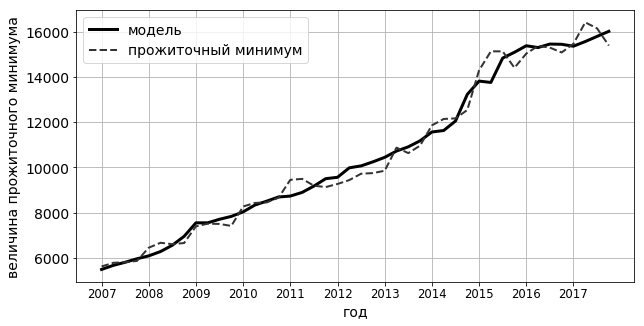

In [4]:
plt.figure(figsize=(10,5))
plt.plot(predict,label="модель", c='#000000', lw=3, linestyle='-')
plt.plot(y,label="прожиточный минимум", c='#333333', lw=2, linestyle='--')
plt.legend()
plt.xticks(range(0,len(data), 4), range(2007, 2018), size='small')
plt.grid(True)
plt.xlabel('год')
plt.ylabel('величина прожиточного минимума')
plt.show()